# ECE-6524 / CS-6524 Deep Learning
# Assignment 1 [90 pts]

In this assignment, **you need to complete the following three sectoins**:
1. SVM Classifier
    - Calculating loss and gradient
2. Linear Classfier with Softmax 
    - Calculating loss and gradient
3. Simple Neural Network with Multilayer Perceptrons
    - Read the forward and backward propogation
    - Experiment with simple NN

This assignment is inspired and adopted from Stanford CS231n, UIUC Deep Learning course and Deep Learning Lab from Professor Vicente Ordonez at the University of Virginia.
## Submission guideline

1. Click the Save button at the top of the Jupyter Notebook.
2. Please make sure to have entered your Virginia Tech PID below.
3. Select Cell -> All Output -> Clear. This will clear all the outputs from all cells (but will keep the content of ll cells).
4. Select Cell -> Run All. This will run all the cells in order.
5. Once you've rerun everything, select File -> Download as -> PDF via LaTeX
6. Look at the PDF file and make sure all your solutions are there, displayed correctly. 
7. Zip BOTH the PDF file and this notebook. Rem
8. Submit your zipped file.

**While you are encouraged to discuss with your peers, <span style="color:blue">all work submitted is expected to be your own.</span> <span style="color:red">If you use any information from other resources (e.g. online materials), you are required to cite it below you VT PID. Any violation will result in a 0 mark for the assignment.</span>**

### Please Write Your VT PID Here: 
### Reference (if any):

In this homework, you would need to use **Python 3.6+** along with the following packages:
```
1. numupy
2. matplotlib
3. scipy
```
All packages above can be installed through `pip install`.

In addition, you will need to have [CIFAR10](https://www.cs.toronto.edu/~kriz/cifar.html) dataset in your `cifar10/cifar-10-batches-py` folder. We provide a bash script `cifar10/get_dataset.sh` to help you download and unpack the dataset.

Once you are done with the things above, you can proceed to execute the following cells:

In [1]:
import random
import numpy as np
from data_process import get_CIFAR10_data
import math
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2
%matplotlib inline

# Loading CIFAR-10

In the following cells, we would first load the CIFAR10 dataset, and prepare them for our classifier:

In [2]:
# You can change these numbers for experimentation
# For submission we will use the default values 
TRAIN_IMAGES = 49000
VAL_IMAGES = 1000
TEST_IMAGES = 1000

In [3]:
data = get_CIFAR10_data(TRAIN_IMAGES, VAL_IMAGES, TEST_IMAGES, subtract_mean=False)
X_train, y_train = data['X_train'], data['y_train']
X_val, y_val = data['X_val'], data['y_val']
X_test, y_test = data['X_test'], data['y_test']

In [4]:
print(X_train.shape)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)
print(X_test.shape)
print(y_test.shape)

(49000, 32, 32, 3)
(49000,)
(1000, 32, 32, 3)
(1000,)
(1000, 32, 32, 3)
(1000,)


Now, we visualize the dataset to get a better idea of it.

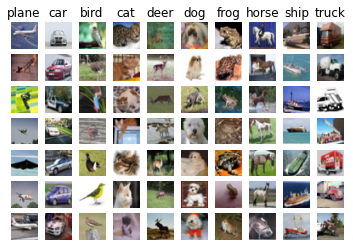

In [5]:
# Visualize some examples from the dataset.
# We show a few examples of training images from each class.
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
samples_per_class = 7
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X_train[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

We then subtract all the images with the **mean image** of the training set. This trick is commonly used in Computer Vision community, as it arranges the features into a range that is more manageable for the models.

In [6]:
mean_image = np.mean(X_train, axis=0)
X_train -= mean_image
X_val -= mean_image
X_test -= mean_image

Now, we convert the sets of images from dimensions of **(N, 3, 32, 32) -> (N, 3072)** where N is the number of images so that each **3x32x32** image is represented by a single vector. This allows us to feed the data into our classifiers.

In [7]:
X_train = np.reshape(X_train, (X_train.shape[0], -1))
X_val = np.reshape(X_val, (X_val.shape[0], -1))
X_test = np.reshape(X_test, (X_test.shape[0], -1))

In [8]:
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(49000, 3072)
(1000, 3072)
(1000, 3072)


Here, we concatenate all the features with ones. This trick is particularly convenient, as in this case, we only need to deal with a single weight matrix $W$ instead of both $W$ and bias $b$ in our training code.

In [9]:
X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])

In [10]:
# you should get the following output:
# (49000, 3073)
# (1000, 3073)
# (1000, 3073)
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(49000, 3073)
(1000, 3073)
(1000, 3073)


### Calculate Classification Accuracy

Here is a simple helper function for calculation the classification accuracy:

In [11]:
def get_acc(pred, y_test):
    return np.sum(y_test==pred)/len(y_test)*100

In [12]:
# test get_acc
print(get_acc(y_train, y_train))

100.0


# Section 1. Support Vector Machines (with SGD) [30 pts]

In this section, you will need to implement a **soft margin SVM** for a **multi-class classification problem**. In the soft margin SVM, you will maximize the margin between positive and negative training examples and penalize margin violations using a hinge loss.

We will optimize the SVM loss using SGD. This means you must compute the loss function with respect to model weights. You will use this gradient to update the model weights.

SVM optimized with SGD has 3 hyperparameters that you can experiment with :
- `lr` - the learning rate of your model. This parameter scales by how much the weights are changed according to the calculated gradient update
- `n_iter` - the number of training batches you are gonna use for updating your model.
- `reg_const` - Hyperparameter to determine the strength of regularization. In this case it is a coefficient on the term which maximizes the margin.

## 1.1. Implementing SVM with SGD [25 pts]

Recall that the multiclass SVM loss can be written as:
\begin{align}
\begin{gathered}
s=f(x_i, W) \\
L_i = \sum_{j\neq y_i} \left[ \max(0, s_j - s_{y_i} + margin) \right]
\end{gathered}
\end{align}
where $s={s_j}$ is the vector of prediction scores of all class, $s_j$ is the prediction score for class $j$, and $y_i$ is the groud truth class label. The margin is usually set to 1. Now, to learn the weights $W$, we can differentiate the function $L_i$ to get the gradient:
\begin{equation}
\begin{gathered}
\nabla_{w_{y_i}} L_i = - \left( \sum_{j\neq y_i} \mathbb{1}(w_j^Tx_i - w_{y_i}^Tx_i + 1 > 0) \right) x_i\\
\end{gathered}
\end{equation}
where $\mathbb{1}$ is the indicator function that is one if the condition inside is true or zero otherwise, and $w_j$ represents the row $j$ in your weight matrix $W$. To implement this, you’d simply count the number of classes that didn’t meet the desired margin 1 (and hence contributed to the loss function) and then the data vector $x_i$ scaled by this number is the gradient. Note that, in the equation above, we are only calculating the gradient with respect to the row of $W$ that corresponds to the correct class $y_i$. For the other rows $j\neq y_i$, we have:
\begin{equation}
\nabla_{w_j} L_i = \mathbb{1}(w_j^Tx_i - w_{y_i}^Tx_i + 1 > 0) x_i
\end{equation}
Now, we have derived the gradient expression above, it is time to turn these equations into the actual running code.
We provide a template for implementing your SVM classfier below. You have to fill in the **TODO** part, and train your classifier.

In [64]:
 class SVM():
    def __init__(self, input_size, output_size):
        self.input_size = input_size
        self.output_size = output_size
        self.w = np.random.randn(input_size, output_size) * 0.001

In [65]:
def calc_grad_and_loss(self, X_train, y_train, reg, margin, W):
        W = np.random.randn(3073, 10) * 0.0001 
        loss, grad = svm_loss_naive(W, X_dev, y_dev, 0.000005)
        f = lambda w: svm_loss_naive(w, X_dev, y_dev, 0.0)[0]
        grad_numerical = grad_check_sparse(f, W, grad)
        
        """
          Calculate gradient of the svm hinge loss.
          
          Inputs have dimension D, there are C classes, and we operate on minibatches
          of N examples.

          Inputs:
          - X_train: A numpy array of shape (N, D) containing a minibatch of data.
          - y_train: A numpy array of shape (N,) containing training labels; y[i] = c means
            that X[i] has label c, where 0 <= c < C.
          - reg: A float number Regularization strength;
          - margin: A float number margin for the multi-class SVM loss (usually set to 1);

          Returns:
          - gradient with respect to weights w; an array of same shape as w;
          - multi-class SVM loss;
        """
        return grad_w, loss
    

In [66]:
def train(self, X_train, y_train, lr=0.01, reg_const=0.05, margin=1.0, 
        n_iters=1500, batch_size=200):
        y_train_pred = svm.predict(X_train)
        print('training accuracy: %f' % (np.mean(y_train == y_train_pred), ))
        y_val_pred = svm.predict(X_val)
        print('validation accuracy: %f' % (np.mean(y_val == y_val_pred), ))
        loss_hist = []

        for i in range(n_iter):
            batch_indices = np.random.choice(len(X_train), batch_size)
            X_batch = X_train[batch_indices]
            y_batch = y_train[batch_indices]
            grad, loss = self.calc_grad_and_loss(X_batch, y_batch, reg_const, margin)
            self.w -= lr * grad
            if (i + 1) % 100 == 0:
                print(f'Iter {i+1}/{n_iter} - loss: {loss} ')
            loss_hist.append(loss)
        return loss_hist

In [67]:
def predict(self, X_test):
        X_test_predict = np.predict(X_test == X_test_pred)
        print('linear SVM on raw pixels final test set accuracy: %f' % test_accuracy)
        X_train -= mean_image
        X_val -= mean_image
        X_test -= mean_image
        X_dev -= mean_image
        return pred

### Train your SVM
Now, train your SVM classifier. You should expect the loss decreases as the training goes on.

In [72]:
# We will also make a development set, which is a small subset of
# the training set.
mask = np.random.choice(num_training, num_dev, replace=False)
X_dev = X_train[mask]
y_dev = y_train[mask]

# We use the first num_test points of the original test set as our
# test set.
mask = range(num_test)
X_test = X_test[mask]
y_test = y_test[mask]
        
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])

print(X_train.shape, X_val.shape, X_test.shape, X_dev.shape)

Train data shape:  (49000, 3076)
Train labels shape:  (49000,)
Validation data shape:  (1000, 3076)
Validation labels shape:  (1000,)
Test data shape:  (1000, 3076)
Test labels shape:  (1000,)
(49000, 3077) (1000, 3077) (1000, 3077) (500, 3077)


### Plot the Loss Curve
Plotting the loss curve is a proper etiquette for Machine Learning/Deep Learning practitioner.

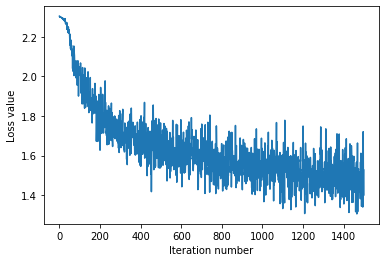

In [73]:
plt.plot(loss_hist)
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.show()

### Accuracy?
If the SVM is implemented correctly, you shuold get an training/validation accuracy around 34%-35%.

In [74]:
y_train_pred = svm.predict(X_train)
print('training accuracy: %f' % (np.mean(y_train == y_train_pred), ))
y_val_pred = svm.predict(X_val)
print('validation accuracy: %f' % (np.mean(y_val == y_val_pred), ))

NameError: name 'x_test' is not defined

## Section 1.2. Improve your SVM [5 pts]
Now, try to improve the accuracy of your classifier. You can perform hyperparameter search with cross-validation, or conduct some extra preprocessing on the data. **Note that you should never use the `X_test` and `y_test` for tuning your model.**

In [26]:
# How can you improve it? 

### Test SVM
Evaluate the testing accuracy of your SVM:

In [79]:
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)
svm = LinearSVM()
tic = time.time()
loss_hist = svm.train(X_train, y_train, learning_rate=1e-7, reg=2.5e4,
                      num_iters=1500, verbose=True)
toc = time.time()
print('That took %fs' % (toc - tic))

Test data shape:  (1000, 3077)
Test labels shape:  (1000,)


NameError: name 'LinearSVM' is not defined

### Visualization
Visualize the weights of your best model. 

In [28]:
# Visualize the learned weights for each class.
# Hint: reshape your weights (w/o bias) to (32, 32, 3, 10), then use min-max normalization and rescale them back to 0-255.
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
w = best_svm.W[:-1,:] # strip out the bias
w = w.reshape(32, 32, 3, 10)
w_min, w_max = np.min(w), np.max(w)
# plot for each class
for i in range(10):
    plt.subplot(2, 5, i + 1)
      
    # Rescale the weights to be between 0 and 255
    wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
    plt.imshow(wimg.astype('uint8'))
    plt.axis('off')
    plt.title(classes[i])


NameError: name 'best_svm' is not defined

Describe what your visualized SVM weights look like, and offer a brief explanation for why they look the way that they do.

Your comments:

# Section 2. Softmax Classifier (with SGD) [30 pts]

Next, you will train a Softmax classifier. This classifier consists of a linear function of the input data followed by a softmax function which outputs a vector of dimension C (number of classes) for each data point. Each entry of the softmax output vector corresponds to a confidence in one of the C classes, and like a probability distribution, the entries of the output vector sum to 1. 

## Section 2.1. Implement the Softmax Classifier [25 pts]
Recall that, from the lecture, we can write down the loss function as:
\begin{align}
\begin{gathered}
s=f(x_i, W) \\
L_i = -\log\left({\frac{e^{s_{y_i}}} {\sum_j e^{s_j}} }\right)
\end{gathered}
\end{align}

And, through some calculations, we can obtain the expression for the gradient:
\begin{align}
\nabla_{w_{l}} L_i = \left(\frac{e^{w_l^Tx_i}} {\sum_j e^{w_j^Tx_i}} - \mathbb{1}\left(y_i=l\right)\right) x_i\\
\end{align}


The softmax classifier also has 3 hyperparameters that you can experiment with :
- `lr` - the learning rate of your model. This parameter scales by how much the weights are changed according to the calculated gradient update
- `n_iter` - the number of training batches you are gonna use for updating your model.
- `reg_const` - Hyperparameter to determine the strength of regularization. In this case it is a coefficient on the term which maximizes the margin.

Same as the previous section, we provide a template for you to implement your classifier:

In [29]:
 class Softmax_Classfier():
    def __init__(self, input_size, output_size):
        """
        Initialises Softmax classifier with initializing 
        weights, alpha(learning rate), number of epochs
        and regularization constant.
        """
        self.input_size = input_size
        self.output_size = output_size
        self.w = np.random.randn(input_size, output_size) * 0.001

In [ ]:
    def softmax(self, logits):
        ################################################################################
        # TODO:                                                                        #
        # Implement the softmax function here.                                         #
        ################################################################################

        ################################################################################
        #                                 END OF YOUR CODE                             #
        ################################################################################
        return probs

In [ ]:
    def calc_grad_and_loss(self, X_train, y_train, reg_const, W):
        """
          Calculate gradient of the svm hinge loss.
          
          Inputs have dimension D, there are C classes, and we operate on minibatches
          of N examples.

          Inputs:
          - X_train: A numpy array of shape (N, D) containing a minibatch of data.
          - y_train: A numpy array of shape (N,) containing training labels; y[i] = c means
            that X[i] has label c, where 0 <= c < C.
          - reg: A float number Regularization strength;

          Returns:
          - gradient with respect to weights w; an array of same shape as w;
          - multi-class SVM loss;
         """ 
        W = np.random.randn(3073, 10) * 0.0001
        loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)
        return grad_w, loss

In [ ]:
    def train(self, X_train, y_train, lr=0.01, reg_const=0.05, 
              n_iters=1500, batch_size=200):
        """
        Train softmax classifier by taking one Stochastic Gradient Descent update
        on the input minibatch.

        Inputs:
        - X_train: A numpy array of shape (N, D) containing training data;
        N examples with D dimensions
        - y_train: A numpy array of shape (N,) containing training labels;
        - lr: A float number learning rate;
        - reg_const: A float number Regularization strength;
        - n_iters: An integer number indicating the number of training iteration;
        - batch_size: An integer indicating the number of samples per batch;
        Returns:
        - loss: Loss for this particular input batch.
        """
        loss_hist = []

        for i in range(n_iter):
            batch_indices = np.random.choice(len(X_train), batch_size)
            X_batch = X_train[batch_indices]
            y_batch = y_train[batch_indices]
            grad, loss = self.calc_grad_and_loss(X_batch, y_batch, reg_const)
            self.w -= lr * grad
            if (i + 1) % 100 == 0:
                print(f'Iter {i+1}/{n_iter} - loss: {loss} ')
            loss_hist.append(loss)
        return loss_hist

In [ ]:
    def predict(self, X_test):
        """
        Use the trained weights of svm classifier to predict labels for
        data points.

        Inputs:
        - X_test: A numpy array of shape (N, D) containing training data; there are N
          training samples each of dimension D.

        Returns:
        - pred: Predicted labels for the data in X_test. pred is a 1-dimensional
          array of length N, and each element is an integer giving the predicted
          class.
        """
        ################################################################################
        # TODO:                                                                        #
        # Make a prediction based on your classifier weights                           #
        ################################################################################
        
        ################################################################################
        #                                 END OF YOUR CODE                             #
        ################################################################################
        return pred

In [81]:
from Assignment1.cs231n.classifiers import LinearSVM
svm = LinearSVM()
tic = time.time()
loss_hist = svm.train(X_train, y_train, learning_rate=1e-7, reg=2.5e4,
                      num_iters=1500, verbose=True)
toc = time.time()
print('That took %fs' % (toc - tic))

ModuleNotFoundError: No module named 'cs231n'

Again, plot the loss:

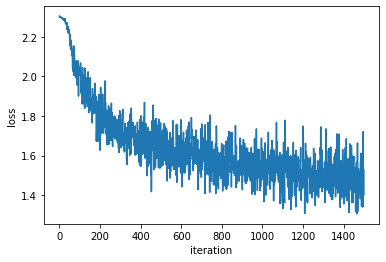

In [52]:
plt.plot(loss_hist);
plt.ylabel('loss');
plt.xlabel('iteration');

### Accuracy?
If the Softmax Classifier is implemented correctly, you shuold get an accuracy around 29%.

In [32]:
pred_softmax = softmax_classifier.predict(X_train)
print('The training accuracy is given by : %f' % (get_acc(pred_softmax, y_train)))
pred_softmax = softmax_classifier.predict(X_val)
print('The validation accuracy is given by : %f' % (get_acc(pred_softmax, y_val)))

NameError: name 'pred' is not defined

## Section 2.1. Improve your Softmax Classifier [5 pts]
Again, try to improve the accuracy of your classifier. You can perform hyperparameter search with cross-validation, or conduct some extra preprocessing on the data. **Note that you should never use the `X_test` and `y_test` for tuning your model.** In addition, <span style="color:red">**We expect to see an accuracy around 34% after the improvement.**</span>


In [33]:
# Get the accuracy to above 34%! 
# For hyperparameter search, you can try different combinations of (reg_const, margin, lr)

### Testing Softmax

Finally, evaluate the testing accuracy.

In [34]:
pred_softmax = softmax_classifier.predict(X_test)
print('The testing accuracy is given by : %f' % (get_acc(pred_softmax, y_test)))

NameError: name 'pred' is not defined

### Visualization
Visualize the weights of your best model. 

In [35]:
# Visualize the learned weights for each class.
# Hint: reshape your weights (no bias) to (32, 32, 3, 10), and then rescale them back to 0-255 using min-max normalization.
w = best_softmax.W[:-1,:] # strip out the bias
w = w.reshape(32, 32, 3, 10)
w_min, w_max = np.min(w), np.max(w)
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# plot for each class
for i in range(10):
    plt.subplot(2, 5, i + 1)
    
    # Rescale the weights to be between 0 and 255
    wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
    plt.imshow(wimg.astype('uint8'))
    plt.axis('off')
    plt.title(classes[i])


NameError: name 'best_softmax' is not defined

Describe what your visualized weights look like compared to SVM weights.

Your comments:

# Section 3. Multilayer Perceptron (MLP)
In this section, we present you a modified version of simple neural network from Professor Vicente Ordonez at the University of Virginia. You job is to read through the implementation (optional, but highly recommended), and try the MLP classifier. For additional resources on understanding forward and backpropagation, you can check the materials here: http://cs231n.github.io/optimization-2/

Consider a single-layer supervised neural network that has 4 inputs and 3 outputs. First, let's review the skeleton of a single linear layer neural network. The inputs of the network are the variables $x_1, x_2, x_3, x_4$, or the input vector $\mathbf{x}=[x_1, x_2, x_3, x_4]$, the outputs of the network are $\widehat{y}_1,\widehat{y}_2,\widehat{y}_3$, or the output vector $\widehat{\mathbf{y}}=[$$\widehat{y}$$_1,\widehat{y}_2,\widehat{y}_3]$:

<img src="fig/1_layer_fig.png" width="450"/>

The given $j$-th output $\widehat{y}_j$ of this single linear layer + activation function is computed as follows:

$$\widehat{y}_j= \text{sigmoid}(w_{1j}x_1 + w_{2j}x_2 + w_{3j}x_3 + w_{4j}x_4 + b_j) = \text{sigmoid}\Big(\sum_{i=1}^{i=4}w_{ij}x_{i} + b_j\Big)$$

In matrix notation, this would be: 

\begin{equation}
\begin{bmatrix}
  \widehat{y}_{1} \\ 
  \widehat{y}_{2} \\
  \widehat{y}_{3} 
\end{bmatrix}^T=\mathbf{Sigmoid}\Bigg(
\begin{bmatrix}
  x_{1} \\
  x_{2} \\
  x_{3} \\
  x_{4}
\end{bmatrix}^T
\begin{bmatrix}
  w_{1,1} & w_{1,2} & w_{1,3}\\
  w_{2,1} & w_{3,2} & w_{2,3}\\
  w_{3,1} & w_{3,2} & w_{3,3}\\
  w_{4,1} & w_{4,2} & w_{4,3}
\end{bmatrix}
+
\begin{bmatrix}
  b_{1} \\
  b_{2} \\
  b_{3}
\end{bmatrix}^T\Bigg)
\end{equation}

or more compactly:

\begin{equation}
\widehat{\mathbf{y}}^T = \mathbf{Sigmoid}(\mathbf{x}^T \cdot \mathbf{W} + \mathbf{b}^T)
\end{equation}

The element-wise sigmoid function is: $\mathbf{Sigmoid}(\mathbf{x}) = 1 \;/\; (1 + exp(-\mathbf{x}))$, or alternatively: $\mathbf{Sigmoid}(\mathbf{x}) = exp(\mathbf{x})\;/\;(1 + exp(\mathbf{x}))$. Here the sigmoid is separated logically into an activation layer $\sigma(x)$ and a linear layer $\text{linear}(3,4)$ as illustrated in figure. 

Training these weights $\mathbf{W}$ and biases $\mathbf{b}$ requires having many training pairs $(\widehat{\mathbf{y}}^{(m)}, \mathbf{x}^{(m)})$. The inputs $\mathbf{x}$ can be the pixels of an image, indices of words, the entries in a database, and the outputs $\widehat{\mathbf{y}}$ can also be literally anything, including a number indicating a category, a set of numbers indicating the indices of words composing a sentence, an output image itself, etc.

## 3.1. Forward-propagation

Computing the outputs $\widehat{\mathbf{y}}$ from the inputs $\mathbf{x}$ in this network composed of a single linear layer, and a sigmoid layer, is called forward-propagation. Below is the code that implements these two operations:

In [36]:
import numpy as np
import numpy.matlib

class nn_Sigmoid:
    def forward(self, x):
        return 1 / (1 + np.exp(-x))

class nn_Linear:
    def __init__(self, input_dim, output_dim):
        # Initialized with random numbers from a gaussian N(0, 0.001)
        self.weight = np.matlib.randn(input_dim, output_dim) * 0.001
        self.bias = np.matlib.randn((1, output_dim)) * 0.001
        
    # y = Wx + b
    def forward(self, x):
        return np.dot(x, self.weight) + self.bias
    
    def getParameters(self):
        return [self.weight, self.bias]

# Let's test the composition of the two functions (forward-propagation in the neural network).
x1 = np.array([[1, 2, 2, 3]])
y_hat1 = nn_Sigmoid().forward(nn_Linear(4, 3).forward(x1))
print('x[1] = '+ str(x1))
print('y_hat[1] = ' + str(y_hat1) + '\n')

# Let's test the composition of the two functions (forward-propagation in the neural network).
x2 = np.array([[4, 5, 2, 1]])
y_hat2 = nn_Sigmoid().forward(nn_Linear(4, 3).forward(x2))
print('x[2] = '+ str(x2))
print('y_hat[2] = ' + str(y_hat2) + '\n')

# We can also compute both at once, which could be more efficient since it requires a single matrix multiplication.
x = np.concatenate((x1, x2), axis = 0)
y_hat = nn_Sigmoid().forward(nn_Linear(4, 3).forward(x))
print('x = ' + str(x))
print('y_hat = ' + str(y_hat))

x[1] = [[1 2 2 3]]
y_hat[1] = [[0.49995929 0.50168595 0.49925963]]

x[2] = [[4 5 2 1]]
y_hat[2] = [[0.49920964 0.50199382 0.49816563]]

x = [[1 2 2 3]
 [4 5 2 1]]
y_hat = [[0.50081571 0.49889111 0.50197078]
 [0.50056433 0.49927628 0.502379  ]]


## 3.2. Loss functions.

After computing the output predictions $\widehat{\mathbf{y}}$ it is necessary to compare these against the true values of $\mathbf{y}$. Let's call these true, correct, or desired values $\mathbf{y}$. Typically, a simple loss or cost function is used to measure the degree by which the prediction $\widehat{\mathbf{y}}$ is wrong with respect to $\mathbf{y}$. A common loss function for regression is the sum of squared differences between the prediction and its true value. Assuming a prediction $\widehat{\mathbf{y}}^{(d)}$ for our training sample $\mathbf{x}^{(d)}$ with true value $\mathbf{y}^{(d)}$, then the loss can be computed as:

$$loss(\widehat{\mathbf{y}}^{(d)}, \mathbf{y}^{(d)}) = (\widehat{y}^{(d)}_1 - y^{(d)}_1)^2 + (\widehat{y}^{(d)}_2 - y^{(d)}_2)^2 + (\widehat{y}^{(d)}_3 - y^{(d)}_3)^2 = \sum_{j=1}^{j=3}(\widehat{y}^{(d)}_j - y^{(d)}_j)^2$$

The goal is to modify the parameters [$\mathbf{W}, \mathbf{b}$] in the Linear layer so that the value of $loss(\widehat{\mathbf{y}}^{(d)}, \mathbf{y}^{(d)})$ becomes as small as possible for all training samples in a set $D=\{(\mathbf{x}^{(d)},\mathbf{y}^{(d)})\}$. This would in turn ensure that predictions $\widehat{\mathbf{y}}$ are as similar as possible to the true values $\mathbf{y}$. To achieve this we need to minimize the following function:

$$\mathcal{L}(\mathbf{W}, \mathbf{b}) = \sum_{d=1}^{d=|D|} loss(\widehat{\mathbf{y}}^{(d)}, \mathbf{y}^{(d)})$$

The only two variables for our model in the function $\mathcal{L}(\mathbf{W}, \mathbf{b})$ are $\mathbf{W}$ and $\mathbf{b}$, this is because the training dataset $D$ is fixed. Finding the values of $\mathbf{W}$ and $\mathbf{b}$ that minimize the the loss, particularly for complex functions, is typically done using gradient based optimization, like Stochastic Gradient Descent (SGD). 

In [37]:
class nn_MSECriterion:  # MSE = mean squared error.
    def forward(self, predictions, labels):
        return np.sum(np.square(predictions - labels))

# Let's test the loss function.
y_hat = np.array([[0.23, 0.25, 0.33], [0.23, 0.25, 0.33], [0.23, 0.25, 0.33], [0.23, 0.25, 0.33]])
y_true = np.array([[0.25, 0.25, 0.25], [0.33, 0.33, 0.33], [0.77, 0.77, 0.77], [0.80, 0.80, 0.80]])

nn_MSECriterion().forward(y_hat, y_true)

1.6271000000000002

## 3.3. Backward-propagation (Backpropagation)

As we discussed in class, backpropagation is just applying the chain-rule in calculus to compute the derivative of a function which is the composition of many functions (this is essentially definition of the neural network). 

Below is the implementation of required derivative computations for our simple network. You are highly advised to derive the derivatives implemented here to make sure you understand how one arrives at them. 

In [38]:
# This is referred above as f(u).

class nn_MSECriterion:
    def forward(self, predictions, labels):
        return np.sum(np.square(predictions - labels))
        
    def backward(self, predictions, labels):
        num_samples = labels.shape[0]
        return 2 * (predictions - labels)
    
# This is referred above as g(v).
class nn_Sigmoid:
    def forward(self, x):
        return 1 / (1 + np.exp(-x))
    
    def backward(self, x, gradOutput):
        # It is usually a good idea to use gv from the forward pass and not recompute it again here.
        gv = 1 / (1 + np.exp(-x))
        return np.multiply(np.multiply(gv, (1 - gv)), gradOutput)

# This is referred above as h(W, b)
class nn_Linear:
    def __init__(self, input_dim, output_dim):
        # Initialized with random numbers from a gaussian N(0, 0.001)
        self.weight = np.matlib.randn(input_dim, output_dim) * 0.001
        self.bias = np.matlib.randn((1, output_dim)) * 0.001
        self.gradWeight = np.zeros_like(self.weight)
        self.gradBias = np.zeros_like(self.bias)
        
    def forward(self, x):
        return np.dot(x, self.weight) + self.bias
    
    def backward(self, x, gradOutput):
        # dL/dw = dh/dw * dL/dv
        self.gradWeight = np.dot(x.T, gradOutput)
        # dL/db = dh/db * dL/dv
        #self.gradBias = np.copy(gradOutput)
        self.gradBias = np.copy(np.sum(gradOutput, axis=0))
        # return dL/dx = dh/dx * dL/dv
        return np.dot(gradOutput, self.weight.T)
    
    def getParameters(self):
        params = [self.weight, self.bias]
        gradParams = [self.gradWeight, self.gradBias]
        return params, gradParams
    
# Let's test some dummy inputs for a full pass of forward and backward propagation.
x1 = np.array([[1, 2, 2, 3]])
y1 = np.array([[0.25, 0.25, 0.25]])

# Define the operations.
linear = nn_Linear(4, 3)  # h(W, b)
sigmoid = nn_Sigmoid()  # g(v)
loss = nn_MSECriterion()  # f(u)

# Forward-propagation.
lin = linear.forward(x1)
y_hat = sigmoid.forward(lin)
loss_val = loss.forward(y_hat, y1) # Loss function.

# Backward-propagation.
dy_hat = loss.backward(y_hat, y1)
dlin = sigmoid.backward(lin, dy_hat)
dx1 = linear.backward(x1, dlin)

print('\n num_samples = ' + str(y1.shape[0]))

# Show parameters of the linear layer.
print('\nW = ' + str(linear.weight))
print('B = ' + str(linear.bias))

# Show the intermediate outputs in the forward pass.
print('\nx1    = '+ str(x1))
print('lin   = ' + str(lin))
print('y_hat = ' + str(y_hat))

print('\nloss = ' + str(loss_val))

# Show the intermediate gradients with respect to inputs in the backward pass.
print('\ndy_hat = ' + str(dy_hat))
print('dlin   = ' + str(dlin))
print('dx1    = ' + str(dx1))

# Show the gradients with respect to parameters.
print('\ndW = ' + str(linear.gradWeight))
print('dB = ' + str(linear.gradBias))


 num_samples = 1

W = [[ 2.06867662e-04 -1.23920547e-03  1.54040458e-03]
 [-1.79212337e-03  8.24980191e-04  9.00358657e-04]
 [-1.10821102e-04 -3.97600583e-05  7.11846661e-04]
 [ 1.45669210e-03 -6.06955362e-05 -7.11040888e-04]]
B = [[-8.03844097e-04  8.39551872e-05  9.12792571e-04]]

x1    = [[1 2 2 3]]
lin   = [[-3.27890722e-05  2.33103373e-04  3.54448512e-03]]
y_hat = [[0.4999918  0.50005828 0.50088612]]

loss = 0.18796888813670343

dy_hat = [[0.49998361 0.50011655 0.50177224]]
dlin   = [[0.1249959  0.12502914 0.12544267]]
dx1    = [[ 6.41532779e-05 -7.91812442e-06  7.04725939e-05  8.52969668e-05]]

dW = [[0.1249959  0.12502914 0.12544267]
 [0.2499918  0.25005827 0.25088533]
 [0.2499918  0.25005827 0.25088533]
 [0.3749877  0.37508741 0.376328  ]]
dB = [[0.1249959  0.12502914 0.12544267]]


## 3.4. Gradient checking 

The gradients can also be computed with numerical approximation using the definition of derivatives. Let a single input pair $(\mathbf{x}, \mathbf{y})$ be the input, for each entry $w_{ij}$ in the weight matrix $\mathbf{W}$, the partial derivatives can be computed as follows:

$$\frac{\partial \mathcal{L}(\mathbf{W},\mathbf{b})}{\partial w_{ij}} = \frac{\mathcal{L}(\mathbf{W} + \mathbf{E}_{ij},b) - \mathcal{L}(\mathbf{W} - \mathbf{E}_{ij}, b)}{2\epsilon}, $$

where $\mathbf{E}_{ij}$ is a matrix that has $\epsilon$ in its $(i,j)$ entry and zeros everywhere else. Intuitively this gradient tells how would the value of the loss changes if we change a particular weight $w_{ij}$ by an $\epsilon$ amount. We can do the same to compute derivatives with respect to the bias parameters $b_i$. Below is the code that checks for a given input $(\mathbf{x}, \mathbf{y})$, the gradients for the matrix $\mathbf{W}$. 

In [39]:
# We will compute derivatives with respect to a single data pair (x,y)
x = np.array([[2.34, 3.8, 34.44, 5.33]])
y = np.array([[3.2, 4.2, 5.3]])

# Define the operations.
linear = nn_Linear(4, 3)
sigmoid = nn_Sigmoid()
criterion = nn_MSECriterion()

# Forward-propagation.
a0 = linear.forward(x)
a1 = sigmoid.forward(a0)
loss = criterion.forward(a1, y) # Loss function.

# Backward-propagation.
da1 = criterion.backward(a1, y)
da0 = sigmoid.backward(a0, da1)
dx = linear.backward(x, da0)

gradWeight = linear.gradWeight
gradBias = linear.gradBias

approxGradWeight = np.zeros_like(linear.weight)
approxGradBias = np.zeros_like(linear.bias)

# We will verify here that gradWeights are correct and leave it as an excercise
# to verify the gradBias.
epsilon = 0.0001
for i in range(0, linear.weight.shape[0]):
    for j in range(0, linear.weight.shape[1]):
        # Compute f(w)
        fw = criterion.forward(sigmoid.forward(linear.forward(x)), y) # Loss function.
        # Compute f(w + eps)
        shifted_weight = np.copy(linear.weight)
        shifted_weight[i, j] = shifted_weight[i, j] + epsilon
        shifted_linear = nn_Linear(4, 3)
        shifted_linear.bias = linear.bias
        shifted_linear.weight = shifted_weight
        fw_epsilon = criterion.forward(sigmoid.forward(shifted_linear.forward(x)), y) # Loss function
        # Compute (f(w + eps) - f(w)) / eps
        approxGradWeight[i, j] = (fw_epsilon - fw) / epsilon

# These two outputs should be similar up to some precision.
print('gradWeight: ' + str(gradWeight))
print('\napproxGradWeight: ' + str(approxGradWeight))

gradWeight: [[ -3.16767541  -4.33922282  -5.59491182]
 [ -5.14408827  -7.04660116  -9.08575423]
 [-46.62168421 -63.8644589  -82.34562522]
 [ -7.21526065  -9.88378531 -12.74396581]]

approxGradWeight: [[ -3.16764722  -4.33919908  -5.59485906]
 [ -5.1440139   -7.04653852  -9.08561508]
 [-46.61553404 -63.8592577  -82.33412299]
 [ -7.21511429  -9.88366202 -12.74369194]]


## Section 3.4. Playing with the Simple NN [30 pts]
Now, we provide a simple NN model that has an training accuracy around 46%. You job here is to first run and check the simple NN model, and the experiments it with:
- Try using 3 different numbers of layers for the simple NN, and plot the accuracy as a function of the number of layers. 
- Try 4 different numbers of hidden state size, and plot the accuracy as a function of the number you have tried.
- Try different activation function (Sigmoid, ReLU)
- Briefly describe what you've observed in the above experiments

Note that you are free to create your own Simple_NN class for your experiments.

In [40]:
class nn_CECriterionWithLogits:
    def forward(self, logits, labels):
        y_indices = np.arange(len(labels))
        self.probs = softmax(logits)
        correct_class_prob = self.probs[y_indices, labels].reshape(-1, 1)
        loss = np.sum(-np.log(correct_class_prob)) / len(correct_class_prob)
        return loss
    
    def backward(self, labels):
        y_indices = np.arange(len(labels))
        gradOutput = self.probs
        gradOutput[y_indices, labels] -= 1
        return gradOutput / len(labels)
    
class nn_ReLU:
    def forward(self, x):
        # Forward pass.
        return np.maximum(0, x)
    
    def backward(self, x, gradOutput):
        # Backward pass
        return np.where(x < 0, 0, np.multiply(x, gradOutput))
    
def softmax(x):
    exp = np.exp(x - x.max()) # stability trick
    return (exp / np.sum(exp, axis=1))

In [41]:
class Simple_NN(object):
    def __init__(self, input_size, output_size, hidden_state_size=64):
        self.linear1 = nn_Linear(input_size, hidden_state_size)
        self.activation = nn_ReLU()
        self.linear2 = nn_Linear(hidden_state_size, output_size)
        
    def forward(self, X):
        self.X = X
        self.x1 = self.linear1.forward(self.X)
        self.a1 = self.activation.forward(self.x1)
        logits = self.linear2.forward(self.a1)
        return logits
    
    def backward(self, gradOutput):
        dx2 = self.linear2.backward(self.a1, gradOutput)
        da1 = self.activation.backward(self.x1, dx2)
        self.linear1.backward(self.X, da1)
    
    def update(self, lr):
        self.linear1.weight = self.linear1.weight - lr * (self.linear1.gradWeight)
        self.linear1.bias = self.linear1.bias - lr * (self.linear1.gradBias)
        self.linear2.weight = self.linear2.weight - lr * (self.linear2.gradWeight)
        self.linear2.bias = self.linear2.bias - lr * (self.linear2.bias)
        
    def train(self, X_train, y_train, loss_criterion=nn_CECriterionWithLogits(), 
              lr=1e-5, n_iter=1500, batch_size=200):
        loss_hist = []

        for i in range(n_iter):
            batch_indices = np.random.choice(len(X_train), batch_size)
            X_batch = X_train[batch_indices]
            y_batch = y_train[batch_indices]
            
            logits = self.forward(X_batch)
            loss = loss_criterion.forward(logits, y_batch)
            loss_grad = loss_criterion.backward(y_batch)
            self.backward(loss_grad)
            self.update(lr)

            if (i + 1) % 100 == 0:
                print(f'Iter {i+1}/{n_iter} - loss: {loss} ')
            loss_hist.append(loss)
        return loss_hist
    def predict(self, X):
        return np.asarray(np.argmax(softmax(self.forward(X)), axis=1)).squeeze(1)

As the bias is explicitly handled in the MLP code, stripped off the ones we have concatenated to the feature vectors.

In [42]:
X_train = X_train[:, :3072]
X_val = X_val[:, :3072]
X_test = X_test[:, :3072]

Now, run the simple NN to check the accuracy:

In [43]:
model = Simple_NN(X_train.shape[1], np.max(y_train)+1, hidden_state_size=64)
n_iter = 1500
batch_size = 200
loss_hist = model.train(X_train, y_train, lr=1e-4)

Iter 100/1500 - loss: 2.007907111309604 
Iter 200/1500 - loss: 1.8240251767617672 
Iter 300/1500 - loss: 1.7061228901807564 
Iter 400/1500 - loss: 1.660251191372202 
Iter 500/1500 - loss: 1.541074439578269 
Iter 600/1500 - loss: 1.6543524245114043 
Iter 700/1500 - loss: 1.489208978996445 
Iter 800/1500 - loss: 1.6603099212633612 
Iter 900/1500 - loss: 1.6185442045424652 
Iter 1000/1500 - loss: 1.4940760504301185 
Iter 1100/1500 - loss: 1.396768786530304 
Iter 1200/1500 - loss: 1.486094582058187 
Iter 1300/1500 - loss: 1.4905401645665666 
Iter 1400/1500 - loss: 1.5603511744971001 
Iter 1500/1500 - loss: 1.5268927962002874 


The training accuracy is given by : 48.465306
The training accuracy is given by : 45.700000


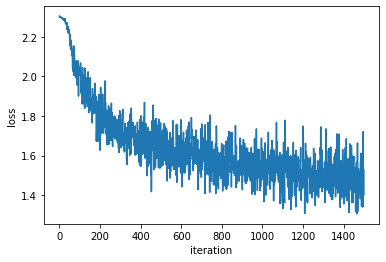

In [44]:
plt.plot(loss_hist);
plt.ylabel('loss');
plt.xlabel('iteration');
predict = model.predict(X_train)
print('The training accuracy is given by : %f' % (get_acc(predict, y_train)))
predict = model.predict(X_val)
print('The training accuracy is given by : %f' % (get_acc(predict, y_val)))

### Section 3.4.1. Different numbers of layers [12 pts]
Try building 3 simple NN with different numbers of layers. Plot the training/validation/test accuracy as a function of the numbers of layers.

In [ ]:
# Type your code here

### Section 3.4.2. Different numbers of hidden state size [7 pts]
Try 4 different numbers of hidden state size, and plot the accuracy as a function of the number you have tried. We recommend you to test numbers like 8, 16, 32, 64, 128, 256. Plot the training/validation/test accuracy as a function of the hidden state size your picked.

In [ ]:
# Type your code here

### Section 3.4.3. Different activation functions [7 pts]
Try both ReLU and Sigmoid activation, and report the training/validation/test accuracy.

In [ ]:
# Type your code here

### Section 3.4.4. What did you see? [4 pts]
Desribe what you see in the experiments above in 5-6 sentences.

Your answer: